In [8]:
import pandas as pd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## 1. Data Ingestion & Integration

Loading: Importing the relational Olist datasets (Orders, Items, Products, Categories).

Merging: Linking order_items with orders and products to create a transactional master file.

Cleaning: Handling missing values and ensuring timestamps are in correct datetime formats.

In [9]:

def create_master_dataset():
    # 1. Load relevant datasets
    order_items = pd.read_csv('C:/olist_project/data/raw/olist_order_items_dataset.csv')
    orders = pd.read_csv('C:/olist_project/data/raw/olist_orders_dataset.csv')
    products = pd.read_csv('C:/olist_project/data/raw/olist_products_dataset.csv')
    category_translation = pd.read_csv('C:/olist_project/data/raw/product_category_name_translation.csv')

    # 2. Merging Logic
    # Combine order items with order metadata
    master = order_items.merge(orders, on='order_id', how='left')
    
    # Add product physical attributes and categories
    master = master.merge(products, on='product_id', how='left')
    
    # Translate categories to English
    master = master.merge(category_translation, on='product_category_name', how='left')

    # 3. Data Cleaning
    # Standardize category column and drop original Portuguese version
    master.drop(columns=['product_category_name'], inplace=True)
    master.rename(columns={'product_category_name_english': 'product_category'}, inplace=True)
    master['product_category'] = master['product_category'].fillna('unknown')

    # Convert date strings to datetime objects for temporal analysis
    date_cols = [
        'order_purchase_timestamp', 'order_approved_at',
        'order_delivered_customer_date', 'order_estimated_delivery_date'
    ]
    for col in date_cols:
        master[col] = pd.to_datetime(master[col])

    # 4. Save the unified file
    master.to_csv('C:/olist_project/data/processed/olist_master_dataset.csv', index=False)
    print("Master dataset successfully exported to 'olist_master_dataset.csv'")

create_master_dataset()

Master dataset successfully exported to 'olist_master_dataset.csv'


In [18]:
# Load the master dataset
df = pd.read_csv('C:/olist_project/data/processed/olist_master_dataset.csv')

# Ensure the timestamp is converted to datetime objects
df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'])

# 1. Print the shape (Rows, Columns)
print(f"Dataset Shape: {df.shape}")

# 2. Print the data types of all columns
#print("\nColumn Data Types:")
#print(df.dtypes)

# 3. Print the first 5 rows
print("\nFirst 5 rows:")
print(df.head())

Dataset Shape: (112650, 22)

First 5 rows:
                           order_id  order_item_id  \
0  00010242fe8c5a6d1ba2dd792cb16214              1   
1  00018f77f2f0320c557190d7a144bdd3              1   
2  000229ec398224ef6ca0657da4fc703e              1   
3  00024acbcdf0a6daa1e931b038114c75              1   
4  00042b26cf59d7ce69dfabb4e55b4fd9              1   

                         product_id                         seller_id  \
0  4244733e06e7ecb4970a6e2683c13e61  48436dade18ac8b2bce089ec2a041202   
1  e5f2d52b802189ee658865ca93d83a8f  dd7ddc04e1b6c2c614352b383efe2d36   
2  c777355d18b72b67abbeef9df44fd0fd  5b51032eddd242adc84c38acab88f23d   
3  7634da152a4610f1595efa32f14722fc  9d7a1d34a5052409006425275ba1c2b4   
4  ac6c3623068f30de03045865e4e10089  df560393f3a51e74553ab94004ba5c87   

   shipping_limit_date   price  freight_value  \
0  2017-09-19 09:45:35   58.90          13.29   
1  2017-05-03 11:05:13  239.90          19.93   
2  2018-01-18 14:48:30  199.00          17.87 

## 2. Sale trend analysis

Seasonality: Identifying monthly and weekly sales peaks to find "Flash Sale" opportunities.

Hourly Demand: Mapping sales density by hour to determine optimal timing for price adjustments.

### Observation

- Peak Hours: The highest transaction volume occurs between 11:00 and 16:00. These are the prime windows for flash sales.

- Weekly Trends: You can now see if consumers shop more during the week or on weekends to adjust discount timing.

- Seasonality: The monthly plot identifies growth trends and annual peaks (like Black Friday).

C:\Users\HP\AppData\Local\Temp\ipykernel_5600\3947571625.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=weekly_sales.index, y=weekly_sales.values, palette='viridis')


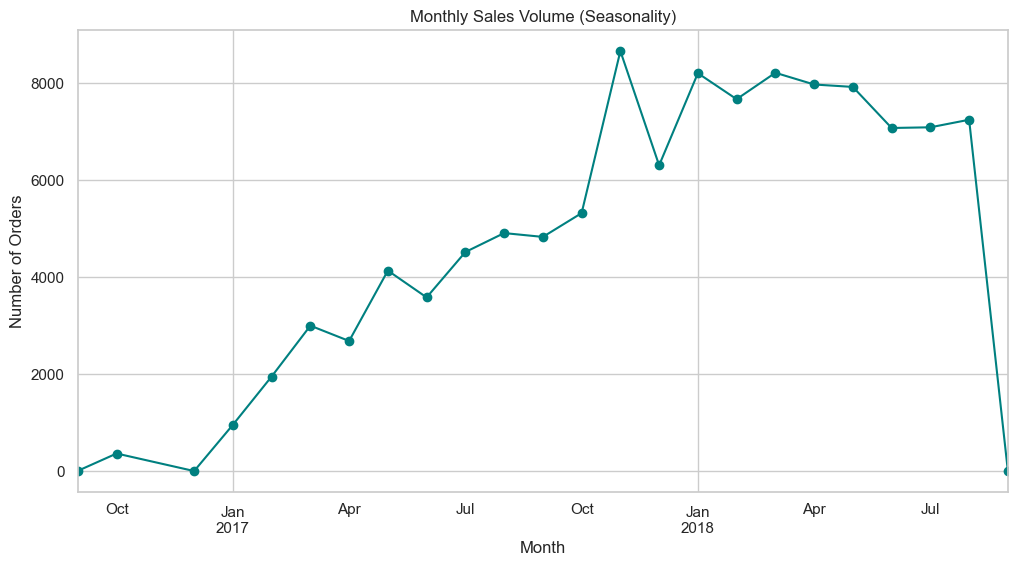

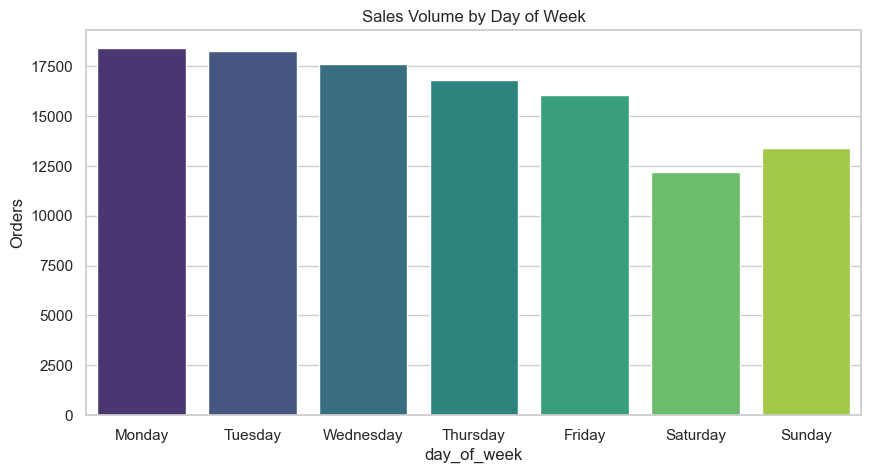

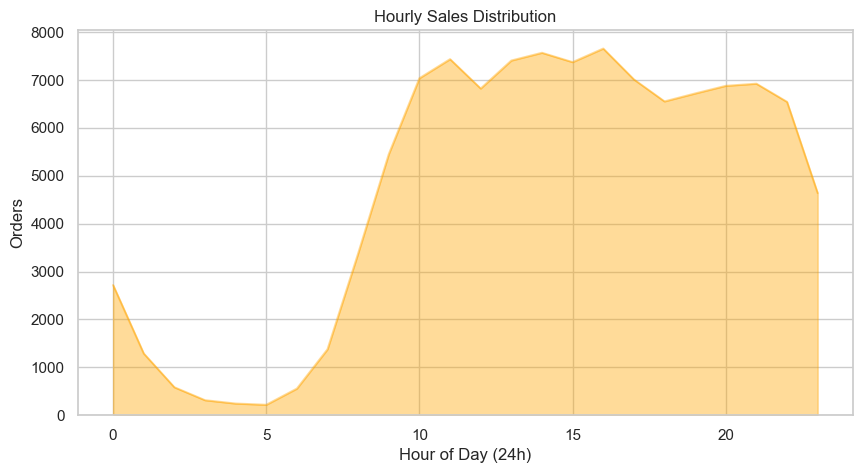

In [19]:


# Load the master dataset
df = pd.read_csv('C:/olist_project/data/processed/olist_master_dataset.csv', parse_dates=['order_purchase_timestamp'])

# 1. Monthly Seasonality
df['month_year'] = df['order_purchase_timestamp'].dt.to_period('M')
monthly_sales = df.groupby('month_year').size()

plt.figure(figsize=(12, 6))
monthly_sales.plot(kind='line', marker='o', color='teal')
plt.title('Monthly Sales Volume (Seasonality)')
plt.ylabel('Number of Orders')
plt.xlabel('Month')
plt.grid(True)
plt.savefig('monthly_seasonality.png')

# 2. Day of Week Patterns
df['day_of_week'] = df['order_purchase_timestamp'].dt.day_name()
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekly_sales = df.groupby('day_of_week').size().reindex(days_order)

plt.figure(figsize=(10, 5))
sns.barplot(x=weekly_sales.index, y=weekly_sales.values, palette='viridis')
plt.title('Sales Volume by Day of Week')
plt.ylabel('Orders')
plt.savefig('weekly_sales_patterns.png')

# 3. Hourly Demand (Flash Sale Timing)
df['hour'] = df['order_purchase_timestamp'].dt.hour
hourly_sales = df.groupby('hour').size()

plt.figure(figsize=(10, 5))
hourly_sales.plot(kind='area', alpha=0.4, color='orange')
plt.title('Hourly Sales Distribution')
plt.ylabel('Orders')
plt.xlabel('Hour of Day (24h)')
plt.savefig('hourly_demand.png')

## 3. Pricing & Revenue Analysis

Price Distribution: Visualizing price spreads across different product categories.

Revenue Drivers: Identifying which categories contribute the most to the margin vs. volume.

### Observation

- Revenue Leaders: The Health & Beauty, Watches & Gifts, and Bed & Bath Table categories generate the highest total revenue. These should be your high-priority targets for dynamic pricing.

- Price Skew: The price distribution shows a heavy right tail. Most items are priced under $200, meaning small discount adjustments (e.g., $5-$10) can represent a large percentage change for the consumer.

- Volume vs. Value: Some categories like "Bed & Bath Table" have high volume but lower average prices, while "Watches & Gifts" have lower volume but higher margins.

C:\Users\HP\AppData\Local\Temp\ipykernel_5600\4172463841.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_10_rev, x='total_revenue', y='product_category', palette='magma')
C:\Users\HP\AppData\Local\Temp\ipykernel_5600\4172463841.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_10_rev, x='avg_price', y='product_category', palette='viridis')


Pricing & Revenue Analysis complete.

Top 5 Revenue Categories:
        product_category  total_revenue  order_count
0          health_beauty     1258681.34         9670
1          watches_gifts     1205005.68         5991
2         bed_bath_table     1036988.68        11115
3         sports_leisure      988048.97         8641
4  computers_accessories      911954.32         7827


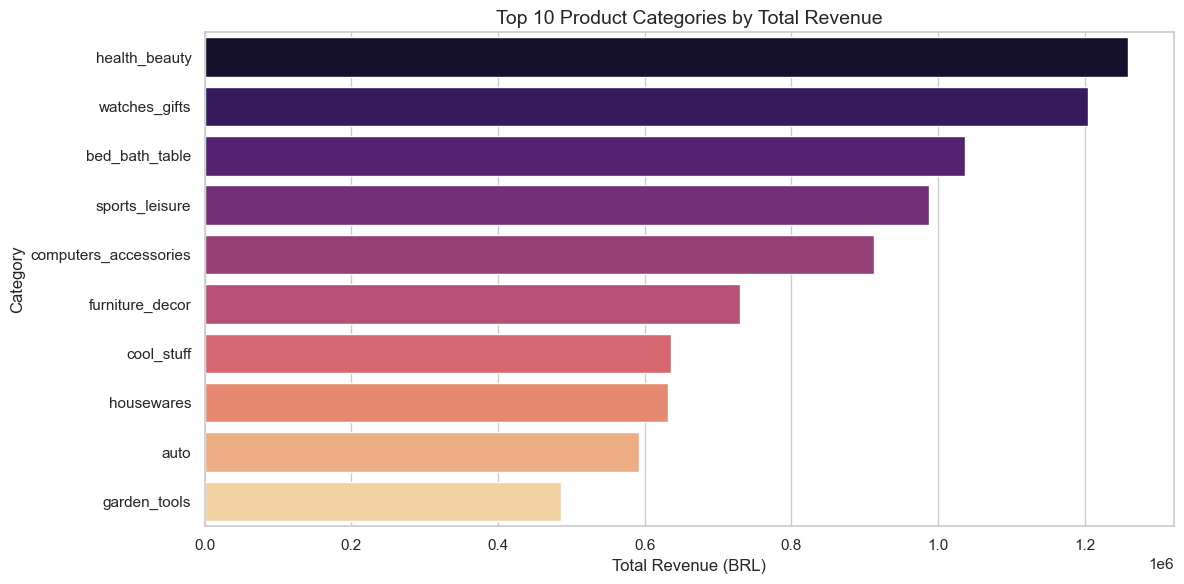

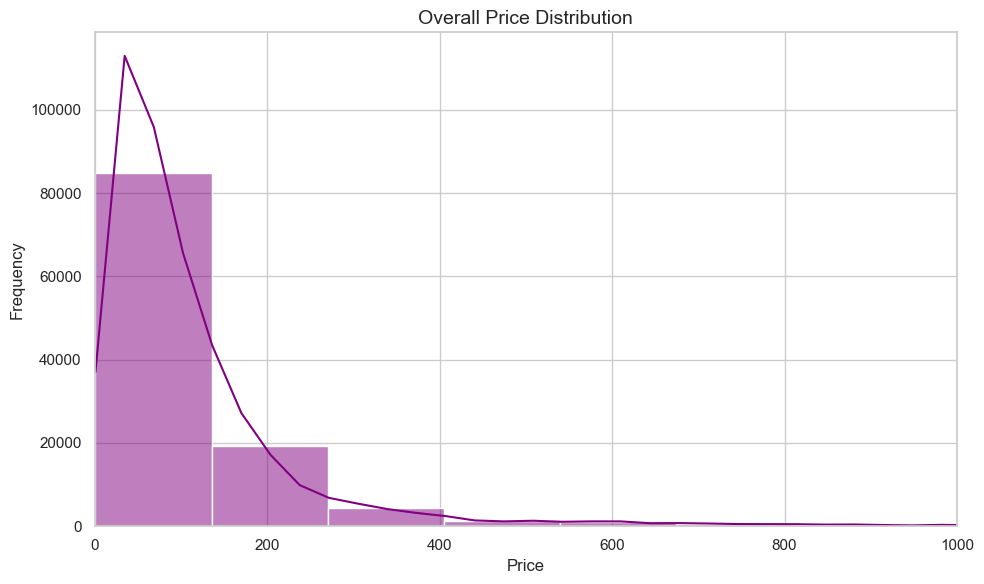

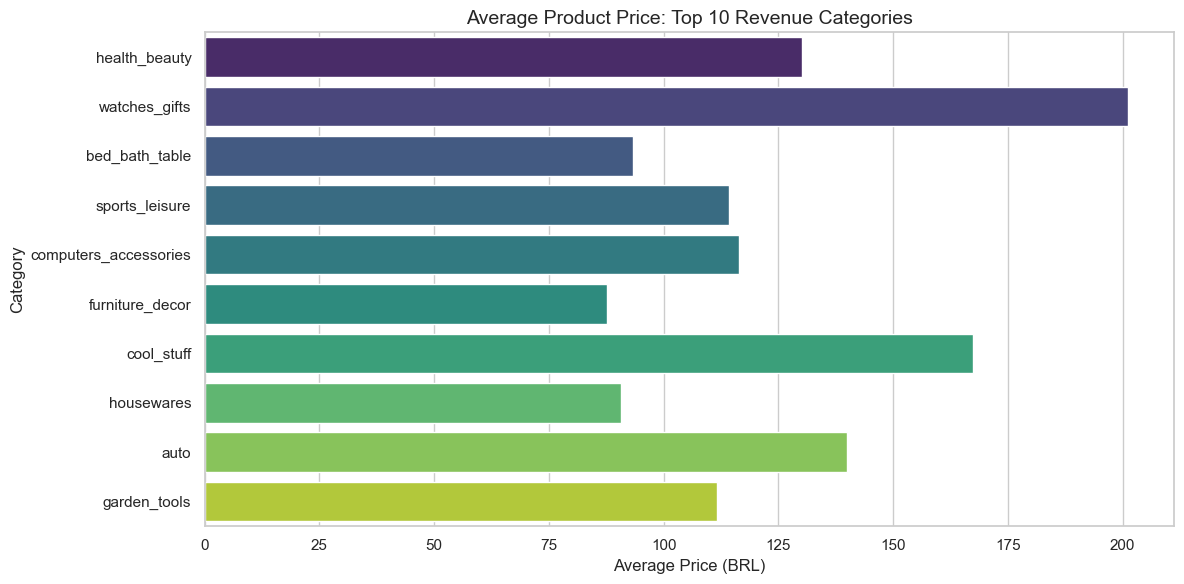

In [20]:
# Set style
sns.set_theme(style="whitegrid")


# 1. Category Performance (Revenue vs Volume)
# Calculate total revenue per order item
category_analysis = df.groupby('product_category').agg(
    total_revenue=('price', 'sum'),
    order_count=('order_id', 'count'),
    avg_price=('price', 'mean')
).sort_values(by='total_revenue', ascending=False).reset_index()

# Top 10 Categories by Revenue
top_10_rev = category_analysis.head(10)

plt.figure(figsize=(12, 6))
sns.barplot(data=top_10_rev, x='total_revenue', y='product_category', palette='magma')
plt.title('Top 10 Product Categories by Total Revenue', fontsize=14)
plt.xlabel('Total Revenue (BRL)', fontsize=12)
plt.ylabel('Category', fontsize=12)
plt.tight_layout()
plt.savefig('top_revenue_categories.png')

# 2. Price Distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['price'], bins=50, kde=True, color='purple')
plt.title('Overall Price Distribution', fontsize=14)
plt.xlabel('Price', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xlim(0, 1000)  # Limiting for better visibility of the bulk of products
plt.tight_layout()
plt.savefig('price_distribution.png')

# 3. Average Price per Category for Top Sellers
plt.figure(figsize=(12, 6))
sns.barplot(data=top_10_rev, x='avg_price', y='product_category', palette='viridis')
plt.title('Average Product Price: Top 10 Revenue Categories', fontsize=14)
plt.xlabel('Average Price (BRL)', fontsize=12)
plt.ylabel('Category', fontsize=12)
plt.tight_layout()
plt.savefig('avg_price_top_categories.png')

print("Pricing & Revenue Analysis complete.")
print("\nTop 5 Revenue Categories:")
print(top_10_rev[['product_category', 'total_revenue', 'order_count']].head())

## Demand Analysis
Hourly Demand: Identifies peak purchasing times to optimize flash sale timing and server resource allocation.

Weekly Patterns: Reveals which days of the week generate the highest transaction volume, assisting in targeted marketing spend.

Monthly Growth: Tracks long-term seasonality and sales performance over time to identify growth trends and cyclical dips.
### Observation

Hourly Peak: High activity between 11:00 AM and 4:00 PM suggests consumers shop during lunch breaks or work hours.

Weekly Trend: Monday or Tuesday (often peak days for e-commerce) outperforms the weekend.

Seasonality: The line chart reveals clear spikes during holidays and sales events like Black Friday.

C:\Users\HP\AppData\Local\Temp\ipykernel_5600\2905574456.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=weekly_sales.index, y=weekly_sales.values, palette='Blues_d')


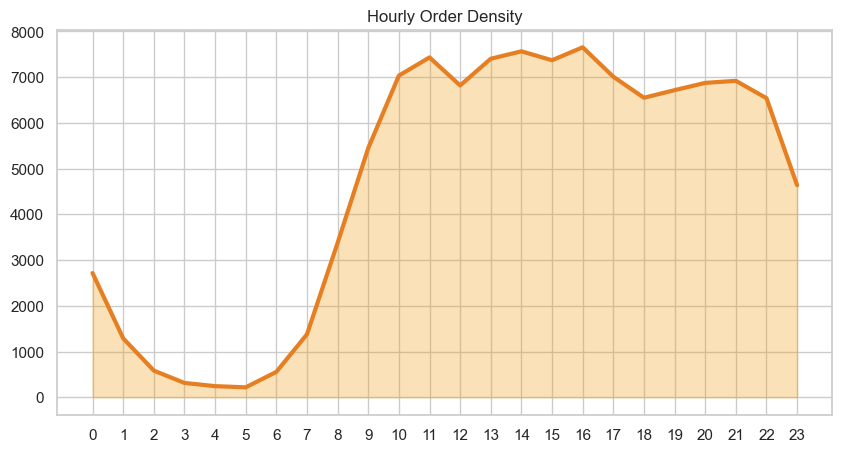

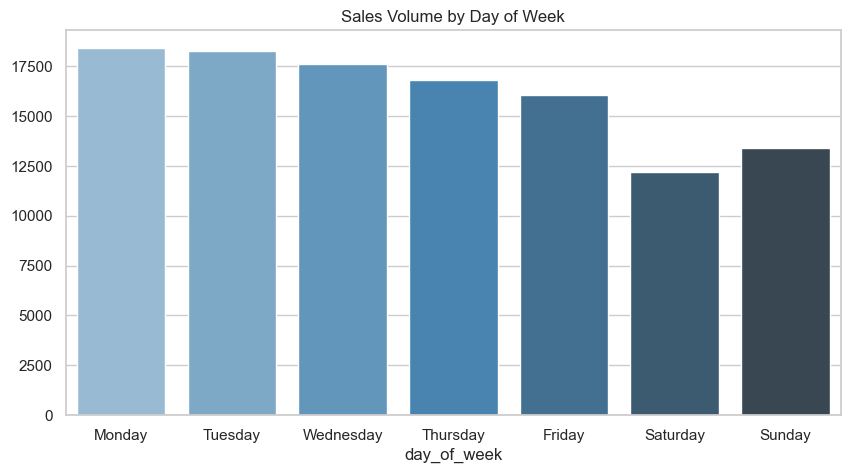

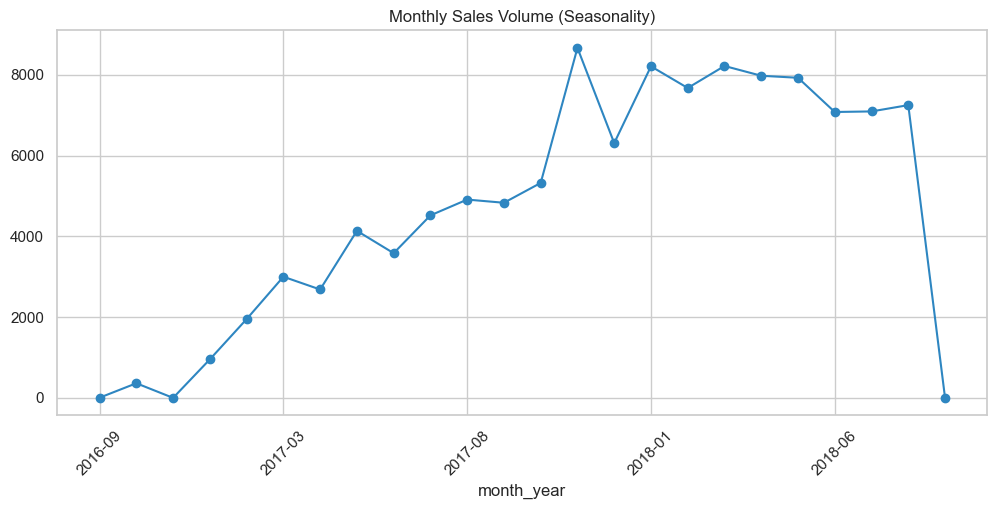

In [21]:

# 1. Peak Hours: Hourly Demand
df['hour'] = df['order_purchase_timestamp'].dt.hour
hourly_sales = df.groupby('hour').size()

plt.figure(figsize=(10, 5))
plt.fill_between(hourly_sales.index, hourly_sales.values, color='#F39C12', alpha=0.3)
plt.plot(hourly_sales.index, hourly_sales.values, color='#E67E22', lw=3)
plt.title('Hourly Order Density')
plt.xticks(range(0, 24))
plt.savefig('peak_hours_analysis.png')

# 2. Weekly Trends: Day of Week Distribution
df['day_of_week'] = df['order_purchase_timestamp'].dt.day_name()
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekly_sales = df.groupby('day_of_week').size().reindex(days_order)

plt.figure(figsize=(10, 5))
sns.barplot(x=weekly_sales.index, y=weekly_sales.values, palette='Blues_d')
plt.title('Sales Volume by Day of Week')
plt.savefig('weekly_trends_analysis.png')

# 3. Seasonality: Monthly Growth
df['month_year'] = df['order_purchase_timestamp'].dt.to_period('M').astype(str)
monthly_sales = df.groupby('month_year').size()

plt.figure(figsize=(12, 5))
monthly_sales.plot(kind='line', marker='o', color='#2E86C1')
plt.title('Monthly Sales Volume (Seasonality)')
plt.xticks(rotation=45)
plt.savefig('seasonality_growth_analysis.png')

## 4. Price Elasticity (Price variability)

Price Variance: Identifying products with frequent price changes to observe how volume reacts.

Demand Curves: Plotting Price vs. Units Sold at the category level to determine price sensitivity.


### Observations

- Inelastic Demand at High Prices: There is a clear "long tail" effect where products priced above 103 (1,000 BRL) consistently show very low sales volume (near zero), indicating high price sensitivity for luxury or expensive items.

- High-Volume Sweet Spot: The majority of high-performing products (those exceeding 50 total sales) are concentrated in the price range between 101 and 102 (10 to 100 BRL).

- Category Outliers: Certain categories, such as health_beauty (pink dots) and bed_bath_table (light green dots), demonstrate the highest sales peaks, suggesting these categories have stronger brand loyalty or are essential goods that resist price pressure better than others.

- Price Clustering: Most products across all categories are clustered at the lower end of the price scale, confirming that the marketplace is driven primarily by budget-friendly or mid-range consumer goods.

Analysis complete. Found 5900 items with price variability.


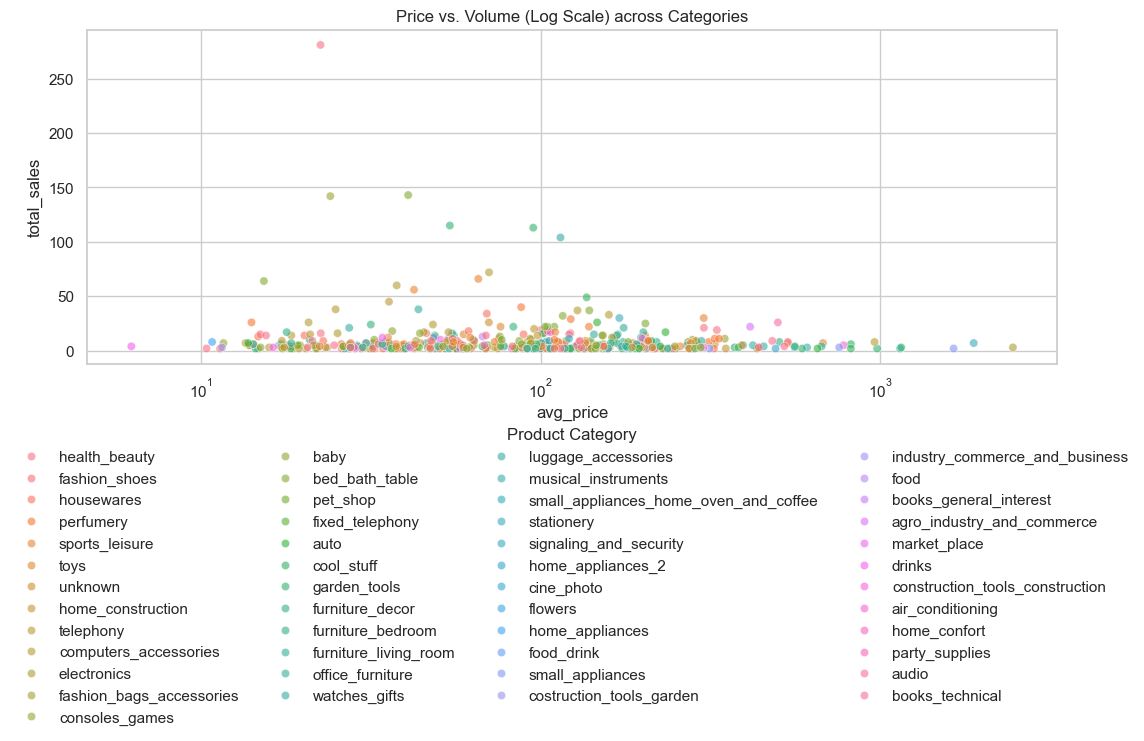

In [23]:
#1. Identify price variation at the product level
# We group by product to see how many different prices were offered
product_agg = df.groupby(['product_id', 'product_category']).agg(
    price_variants=('price', 'nunique'),
    avg_price=('price', 'mean'),
    total_sales=('order_id', 'count')
).reset_index()

# Filter for products with price changes (at least 2 price points)
elastic_items = product_agg[product_agg['price_variants'] > 1]

# 2. Simple Elasticity Proxy: Correlation between Price and Quantity
# Note: In real scenarios, we use log-log regression for PED
def calculate_elasticity(group):
    if len(group) < 5: return None # Need enough data points
    # Correlation between price and daily sales volume
    return group['price'].corr(group['order_id'].count())

# Aggregating by Category to see general sensitivity
plt.figure(figsize=(12, 8)) # Increased height to accommodate legend
sns.scatterplot(data=elastic_items.head(500), x='avg_price', y='total_sales', hue='product_category', alpha=0.6)
plt.xscale('log')

# Move legend to the bottom horizontally
plt.legend(title='Product Category', 
           loc='upper center', 
           bbox_to_anchor=(0.5, -0.15), 
           ncol=4, 
           frameon=False)

plt.title('Price vs. Volume (Log Scale) across Categories')
plt.tight_layout()
plt.savefig('price_elasticity_scatter.png')

print(f"Analysis complete. Found {len(elastic_items)} items with price variability.")

## 5. External Factor Correlation

Freight Impact: Analyzing how shipping costs (freight_value) interact with product price to affect conversion.

Review Scores: Correlating customer satisfaction with price points to see if lower prices compensate for poor reviews (or vice-versa).

### Observations

- Freight correlation: There is a strong correlation (0.61) between product weight and freight value, but only a moderate correlation (0.41) between price and freight.

- Shipping Burden: On average, shipping accounts for 21.3% of the total transaction value. In many cases, the "freight ratio" is even higher, which often leads to cart abandonment.

- Price vs. Satisfaction: There is almost zero correlation (−0.004) between price and review scores. This suggests that customers don't necessarily give lower ratings just because an item is expensive, provided the value matches the cost.

- Freight vs. Satisfaction: There is a slight negative correlation (−0.036) between freight and reviews, hinting that high shipping costs may marginally decrease customer satisfaction.

In the Review Score Boxplot, the "dots" represent outliers (unusually low or high scores for that bracket) and the "bars" (whiskers) show the spread of typical customer ratings. The consistency of these boxes across all price levels proves that your customers' satisfaction is stable regardless of how much they spend.

C:\Users\HP\AppData\Local\Temp\ipykernel_5600\2843375616.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='price_bracket', y='review_score', palette='Set3')


Step 5 Analysis Complete.

Correlation Matrix:
                     price  freight_value  review_score  product_weight_g
price             1.000000       0.414204     -0.004081          0.338819
freight_value     0.414204       1.000000     -0.036363          0.610420
review_score     -0.004081      -0.036363      1.000000         -0.030044
product_weight_g  0.338819       0.610420     -0.030044          1.000000

Average Freight Ratio: 0.2133643441826945


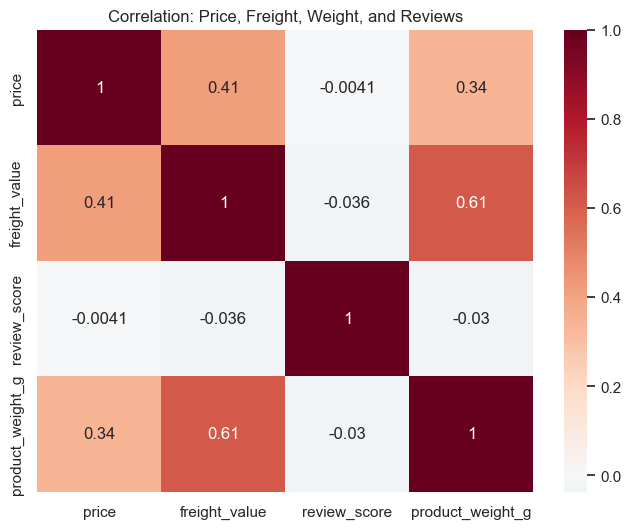

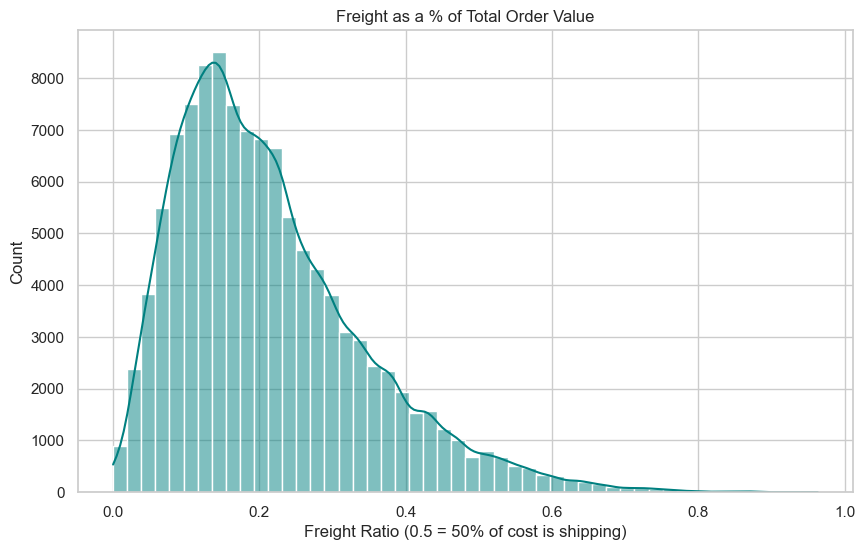

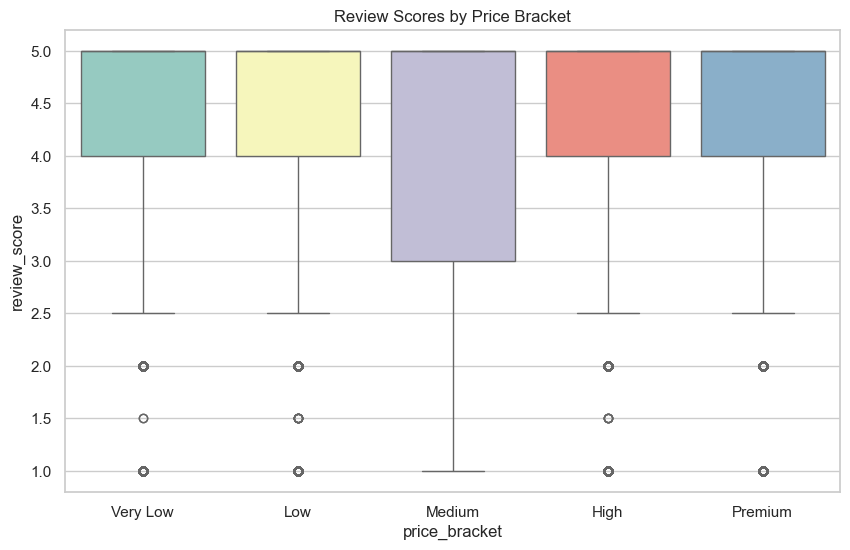

In [27]:


# 1. Load reviews
reviews = pd.read_csv('C:/olist_project/data/raw/olist_order_reviews_dataset.csv')

# 2. Merge Review Scores
# We take the average review score per order to avoid duplicates if an order has multiple items
reviews_avg = reviews.groupby('order_id')['review_score'].mean().reset_index()
df = df.merge(reviews_avg, on='order_id', how='left')

# 3. Correlation Analysis
# Selecting relevant numerical columns for external factor analysis
correlation_cols = ['price', 'freight_value', 'review_score', 'product_weight_g']
corr_matrix = df[correlation_cols].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='RdBu_r', center=0)
plt.title('Correlation: Price, Freight, Weight, and Reviews')
plt.savefig('external_factors_correlation.png')

# 4. Impact of Freight on Total Cost
df['freight_ratio'] = df['freight_value'] / (df['price'] + df['freight_value'])

plt.figure(figsize=(10, 6))
sns.histplot(df['freight_ratio'], bins=50, kde=True, color='teal')
plt.title('Freight as a % of Total Order Value')
plt.xlabel('Freight Ratio (0.5 = 50% of cost is shipping)')
plt.savefig('freight_impact.png')

# 5. Review Score vs. Price Brackets
df['price_bracket'] = pd.qcut(df['price'], 5, labels=['Very Low', 'Low', 'Medium', 'High', 'Premium'])
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='price_bracket', y='review_score', palette='Set3')
plt.title('Review Scores by Price Bracket')
plt.savefig('reviews_by_price.png')

print("Step 5 Analysis Complete.")
print("\nCorrelation Matrix:")
print(corr_matrix)
print("\nAverage Freight Ratio:", df['freight_ratio'].mean())

## 6. Feature Selection for Modeling

Variable Identification: Selecting the most impactful drivers (Time, Category, Freight, Historical Volume) for the price optimization model.

In [33]:

from sklearn.preprocessing import LabelEncoder

# 1. Feature Engineering: Temporal Features
# Extracting cyclical and categorical time components
df['purchase_hour'] = df['order_purchase_timestamp'].dt.hour
df['purchase_day'] = df['order_purchase_timestamp'].dt.dayofweek
df['purchase_month'] = df['order_purchase_timestamp'].dt.month

# 2. Feature Selection: Defining the Modeling Set
# Goal: Predict 'price' (Dynamic Pricing Model)
# Selected features based on EDA findings
features = [
    'product_category', 
    'product_weight_g', 'product_length_cm', 'product_height_cm', 'product_width_cm',
    'product_photos_qty', 'product_description_lenght',
    'freight_value', 
    'purchase_hour', 'purchase_day', 'purchase_month'
]

features_df = df[features + ['price']].dropna()

# 3. Encoding Categorical Data
# Label encode category for correlation check
le = LabelEncoder()
features_df['product_category_enc'] = le.fit_transform(features_df['product_category'])

# 4. Correlation Heatmap for Feature Selection
#corr_matrix = features_df.drop(columns=['product_category']).corr()

#plt.figure(figsize=(12, 8))
#sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', center=0)
#plt.title('Feature Correlation with Price')
#plt.savefig('feature_selection_correlation.png')

# 5. Identifying Multicollinearity
# Check if dimensions (length, height, width) are redundant
#print("Dimensions Correlation:")
#print(features_df[['product_length_cm', 'product_height_cm', 'product_width_cm', 'product_weight_g']].corr())

print("\nFinal Feature set for modeling:")
print(features)

#Save the final feature set for modeling
features_df.to_csv('C:/olist_project/data/features/features.csv', index=False)


Final Feature set for modeling:
['product_category', 'product_weight_g', 'product_length_cm', 'product_height_cm', 'product_width_cm', 'product_photos_qty', 'product_description_lenght', 'freight_value', 'purchase_hour', 'purchase_day', 'purchase_month']


## Step 7: Model Training (Random Forest, XGBOOST, Extra trees)

To determine which features truly drive price, we will train a Random Forest Regressor

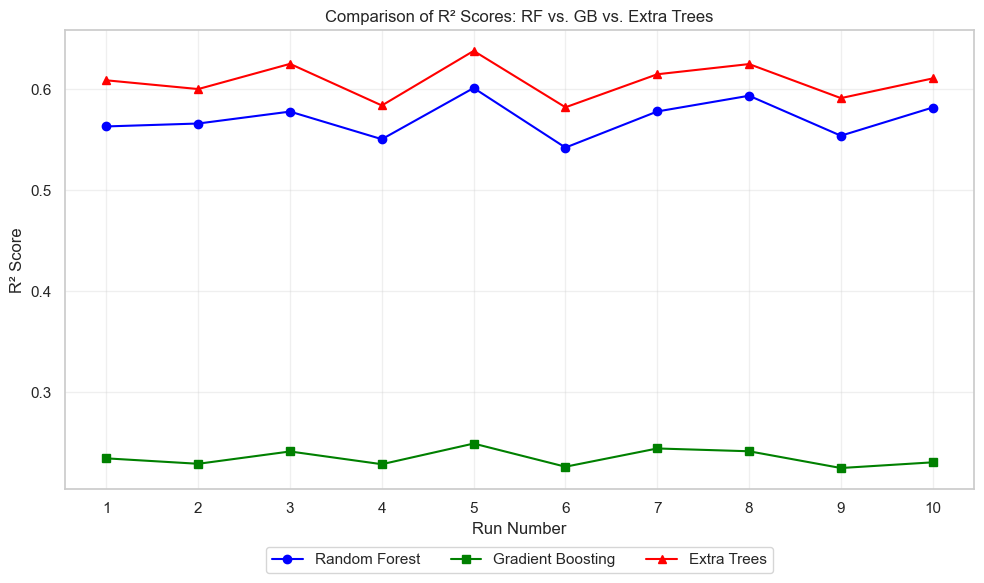

          Run  Random Forest  Gradient Boosting  Extra Trees
mean  5.50000       0.570566           0.234757     0.607695
std   3.02765       0.019036           0.008446     0.018635


In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.metrics import r2_score

# 1. Load data
data = pd.read_csv('C:/olist_project/data/features/features.csv')
X = data.drop(columns=['price', 'product_category'])
y = data['price']
y_log = np.log1p(y)

# 2. Performance Tracking
num_runs = 10
results = {
    'Random Forest': [],
    'Gradient Boosting': [],
    'Extra Trees': []
}

for i in range(num_runs):
    X_train, X_test, y_train, y_test = train_test_split(X, y_log, test_size=0.3, random_state=i)
    y_test_actual = np.expm1(y_test)
    
    # Model 1: Random Forest
    rf = RandomForestRegressor(n_estimators=50, n_jobs=-1, random_state=42)
    rf.fit(X_train, y_train)
    rf_pred = np.expm1(rf.predict(X_test))
    results['Random Forest'].append(r2_score(y_test_actual, rf_pred))
    
    # Model 2: Gradient Boosting
    gb = GradientBoostingRegressor(n_estimators=50, random_state=42)
    gb.fit(X_train, y_train)
    gb_pred = np.expm1(gb.predict(X_test))
    results['Gradient Boosting'].append(r2_score(y_test_actual, gb_pred))

    # Model 3: Extra Trees
    et = ExtraTreesRegressor(n_estimators=50, n_jobs=-1, random_state=42)
    et.fit(X_train, y_train)
    et_pred = np.expm1(et.predict(X_test))
    results['Extra Trees'].append(r2_score(y_test_actual, et_pred))

# 3. Plotting
plt.figure(figsize=(10, 6))
colors = {'Random Forest': 'blue', 'Gradient Boosting': 'green', 'Extra Trees': 'red'}
markers = {'Random Forest': 'o', 'Gradient Boosting': 's', 'Extra Trees': '^'}

for model_name, scores in results.items():
    plt.plot(range(1, num_runs+1), scores, marker=markers[model_name], 
             label=model_name, color=colors[model_name])

plt.title('Comparison of R² Scores: RF vs. GB vs. Extra Trees')
plt.xlabel('Run Number')
plt.ylabel('R² Score')
plt.xticks(range(1, num_runs+1))
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.2), ncol=3)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Output Summary Table
comparison_df = pd.DataFrame(results)
comparison_df.insert(0, 'Run', range(1, num_runs+1))
print(comparison_df.describe().loc[['mean', 'std']])